In [1]:
import torch
import torchvision.transforms as transforms
from datasets import load_metric
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from transformers import VisionEncoderDecoderModel
from transformers import AdamW

import os
import numpy as np
import pandas as pd
from PIL import Image
import numpy as np 
from tqdm import tqdm
from IPython.display import Math, display
from sklearn.model_selection import train_test_split

In [2]:
data_df = pd.read_csv("../Datasets/CROHME/data.csv")[["file_name", "text"]]
data_df["text"] = data_df["text"].apply(lambda x: str(x))

valid = data_df["text"].apply(lambda x: 
     ("frac" not in x) and ("lim" not in x) and (" l i m" not in x)                        
    and ("sum" not in x ) and ("int" not in x ) and ("sqrt" not in x )                    
    and ("mathrm" not in x) and ("left" not in x)                   )

sdata = data_df[valid]

data_df = sdata
data_df.head()

,file_name,text
2,../Datasets/CROHME/crohme_images/0007961.png,x _ { 1 } \times x _ { 2 } \times x _ { 3 } \t...
4,../Datasets/CROHME/crohme_images/0005810.png,2 \pi x y = t
5,../Datasets/CROHME/crohme_images/0005804.png,"\forall x , y"
6,../Datasets/CROHME/crohme_images/0009780.png,a x + b y + c = 0
8,../Datasets/CROHME/crohme_images/0009958.png,y ^ { 2 } = a x ^ { 4 } + 4 b x ^ { 3 } + 6 c ...


In [5]:
train_df, test_df = train_test_split(data_df, train_size = 0.9,test_size=0.1)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

class MathDataset(Dataset):
    def __init__(self, df, processor, max_target_length=256):
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        image = Image.open(file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        labels = self.processor.tokenizer(text, padding="max_length", max_length=self.max_target_length).input_ids
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [6]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = MathDataset(df=train_df,
                           processor=processor)
test_dataset = MathDataset(df=test_df,
                           processor=processor)

print("Train size", len(train_dataset))
print("Test size", len(test_dataset))


from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Train size 4641
Test size 516


(480, 224)
torch.Size([3, 384, 384])


<IPython.core.display.Math object>

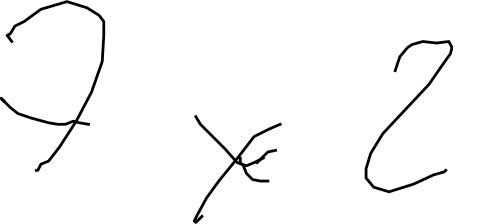

In [7]:
image = Image.open(train_df['file_name'][0]).convert("RGB")
print(image.size)

print(train_dataset[0]["pixel_values"].shape)

display(Math(train_df['text'][0]))
print()
print()
image

In [8]:
device = torch.device("mps")

# pretrained model for handwriting
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")
model.to(device);

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# model config
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

# beam search
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 15
model.config.early_stopping = True
model.config.length_penalty = 1.0
model.repetition_penalty = 1
model.config.num_beams = 1

In [10]:
optimizer = AdamW(model.parameters(), lr = 0.00001) #lr=5e-5)

for epoch in range(5):
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_dataloader):
        for k,v in batch.items():
            batch[k] = v.to(device)

        outputs = model(**batch)
        loss = outputs.loss
        optimizer.zero_grad()  
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
    
    model.save_pretrained("models/finetuning_short_"+str(epoch))

/Users/sadigulcelik/miniconda3/envs/tf_test/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|█████████████████████████████████████████| 581/581 [11:54<00:00,  1.23s/it]


Loss after epoch 0: 0.06629718545657581


100%|█████████████████████████████████████████| 581/581 [11:52<00:00,  1.23s/it]


Loss after epoch 1: 0.02544233849089394


100%|█████████████████████████████████████████| 581/581 [11:53<00:00,  1.23s/it]


Loss after epoch 2: 0.017694848230535007


100%|█████████████████████████████████████████| 581/581 [11:54<00:00,  1.23s/it]


Loss after epoch 3: 0.018610789077500724


100%|█████████████████████████████████████████| 581/581 [11:52<00:00,  1.23s/it]


Loss after epoch 4: 0.019107489244132376


In [48]:
test_model =model.from_pretrained("models/finetuning_short_2")
device2 = torch.device("cpu")
test_model.to(device2);

In [15]:
cer_metric = load_metric("cer")

def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [19]:
test_model.eval()
valid_cer = 0.0
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        outputs = test_model.generate(batch["pixel_values"].to(device2))
        cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
        valid_cer += cer 

print("Test CER:", valid_cer / len(test_dataloader))

100%|███████████████████████████████████████████| 65/65 [00:55<00:00,  1.17it/s]

Test CER: 0.3878298452866645


Validation CER: 0.3878298452866645


In [51]:
original_model =  VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")
original_model.to(device2);

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


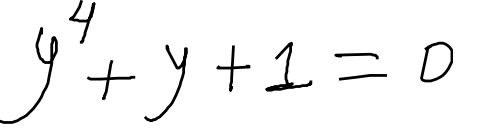

correct output


<IPython.core.display.Math object>



 handwriting model


<IPython.core.display.Math object>

(y't yet 1 - D)


 our model


<IPython.core.display.Math object>

(y ^ { 4 } + y + 1 = 0)


In [52]:
image_ind = 14

image = Image.open(test_df['file_name'][image_ind]).convert("RGB")
pixel_values = processor(image, return_tensors="pt").pixel_values
display(image)
print("correct output")
display(Math(test_df['text'][image_ind]))


generated_ids_orig = original_model.generate(pixel_values.to(device2),max_length = 500)
generated_text_orig = processor.batch_decode(generated_ids_orig, skip_special_tokens=True,max_length = 500)[0]

print("\n\n handwriting model")
display(Math(generated_text_orig))
print("("+generated_text_orig+")")



generated_ids_test = test_model.generate(pixel_values.to(device2),max_length = 500)
generated_text_test = processor.batch_decode(generated_ids_test, skip_special_tokens=True,max_length = 500)[0]

print("\n\n our model")
display(Math(generated_text_test))
print("("+generated_text_test+")")